In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from vae_interp.vae import VAE
from vae_interp.dataset import NpyDataset, load_nouns_dataset
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
import torch
from vae_interp.sae import SAE
from vae_interp.analysis import get_activations_info
from torchvision.transforms import ToPILImage

/home/ubuntu/.cache/pypoetry/virtualenvs/nouns-mech-interp-YeAXWnnL-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dataset = NpyDataset("./vae_embeddings.npy")
dataset[0].shape

torch.Size([64])

In [4]:
nouns_dataset = load_nouns_dataset(image_size=64, normalize=True)

In [5]:
vae = VAE.load_from_dir("./checkpoints/vae")
vae.eval()

VAE(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (1): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (2): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (3): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
  )
  (mu_logvar): Conv2d(256, 8, kernel_siz

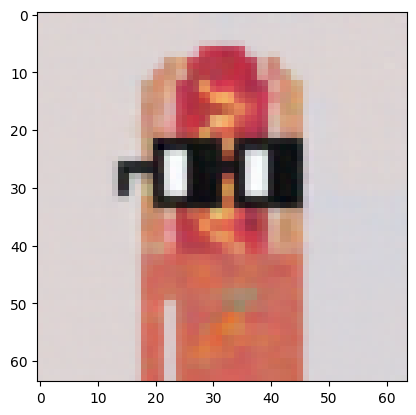

In [6]:
decoded = vae.decode(dataset[0].view(1, 4, 4, 4)).detach().numpy().squeeze(0).transpose(1, 2, 0)
normalized = (decoded - decoded.min()) / (decoded.max() - decoded.min())

plt.imshow(normalized)

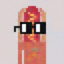

In [7]:
# latent = torch.randn(1, 4, 4, 4)
latent = dataset[0].view(1, 4, 4, 4)
decoded = vae.decode(latent).detach().squeeze(0)
decoded = (decoded - decoded.min()) / (decoded.max() - decoded.min())
image = ToPILImage()(decoded)
image

In [12]:
sae = SAE.load_from_checkpoint("./checkpoints/sae_experiments2/lr=5.0e-04_l1=5.0e-03/sae_config.json",
                               "./checkpoints/sae_experiments2/lr=5.0e-04_l1=5.0e-03/sae.pth")
# sae = SAE.load_from_checkpoint("./checkpoints/sae_experiments2/lr=5.0e-04_l1=1.0e-03/sae_config.json",
#                                "./checkpoints/sae_experiments2/lr=5.0e-04_l1=1.0e-03/sae.pth")
sae.eval()

SAE()

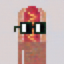

In [13]:
recon_latent = sae(latent.view(1, -1)).recon.view(1, 4, 4, 4)
decoded = vae.decode(recon_latent).detach().squeeze(0)
decoded = (decoded - decoded.min()) / (decoded.max() - decoded.min())
image = ToPILImage()(decoded)
image

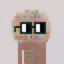

In [22]:
latent = dataset[0].view(1, 4, 4, 4)
latent_flat = latent.view(1, -1)
sparse_latent = sae.encode(latent_flat)

# sparse_latent[0, 2] = 0
# sparse_latent[0, 82] = 0
# sparse_latent[0, 136] = 0
# sparse_latent[0, 164] = 0
# sparse_latent[0, 164] = 0
# sparse_latent[0, 204] = 0
# sparse_latent[0, 211] = 0
# sparse_latent[0, 215] = 0
# sparse_latent[0, 227] = 0
# sparse_latent[0, 263] = 0
# sparse_latent[0, 296] = 0
# sparse_latent[0, 297] = 0
# sparse_latent[0, 315] = 0
# sparse_latent[0, 317] = 0
# sparse_latent[0, 355] = 0
# sparse_latent[0, 381] = 0
# sparse_latent[0, 400] = 0
# sparse_latent[0, 410] = 0
# sparse_latent[0, 450] = 0
# sparse_latent[0, 455] = 0
# sparse_latent[0, 466] = 0

sparse_latent[0, 124] = 0
sparse_latent[0, 155] = 0
sparse_latent[0, 168] = 0
sparse_latent[0, 173] = 0
sparse_latent[0, 183] = 0
sparse_latent[0, 202] = 0

# print(sparse_latent)

recon_latent = sae.decode(sparse_latent).view(1, 4, 4, 4)
# recon_latent = (sae.features[2] + sae.b_d).view(1, 4, 4, 4)
decoded = vae.decode(recon_latent).detach().squeeze(0)
decoded = (decoded - decoded.min()) / (decoded.max() - decoded.min())
image = ToPILImage()(decoded)
image

In [23]:
# get idx that do not equal zero

sparse_latent = sae(latent.view(1, -1)).latent.view(-1)
nonzero_indices = torch.nonzero(sparse_latent).view(-1)

nonzero_indices

tensor([124, 155, 168, 173, 183, 202, 220, 282, 409])

In [24]:
sparse_latent[nonzero_indices]

tensor([0.0235, 0.1297, 0.0723, 0.1899, 0.0407, 2.7225, 0.3785, 0.0438, 0.0219],
       grad_fn=<IndexBackward0>)

In [25]:
feature = sae.features[nonzero_indices] * sparse_latent[nonzero_indices].view(-1, 1)
feature = feature.sum(dim=0)
feature.shape

torch.Size([64])

In [26]:
feature_idx = 0
feature_images_path = f"./data/sae_decoded_features/{feature_idx}.png"

In [27]:
from PIL import Image
import numpy as np

In [28]:
to_image = ToPILImage()

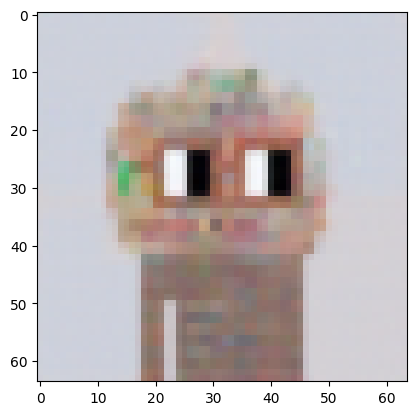

In [29]:
# read image
feature_image = plt.imread(feature_images_path)
feature_image = Image.fromarray((feature_image * 255).astype(np.uint8))
plt.imshow(feature_image)

In [30]:
activations_info = get_activations_info(sae, dataset, batch_size=256, top_k=1, device="cuda")
activations_info

 17%|█▋        | 33/195 [00:00<00:00, 328.60it/s]

100%|██████████| 195/195 [00:01<00:00, 174.31it/s]


ActivationsInfo(activations_per_feature=tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), activation_density_per_feature=tensor([0.0041, 0.0042, 0.0042, 0.0040, 0.0000, 0.0022, 0.0042, 0.0000, 0.0041,
        0.0000, 0.0027, 0.0016, 0.0041, 0.0041, 0.0000, 0.0039, 0.0043, 0.2737,
        0.0000, 0.0036, 0.0000, 0.0042, 0.0038, 0.0043, 0.0035, 0.0019, 0.0043,
        0.0000, 0.0037, 0.0041, 0.0038, 0.0044, 0.2217, 0.1719, 0.0000, 0.0047,
        0.0000, 0.0000, 0.0047, 0.0000, 0.0035, 0.0038, 0.0000, 0.0037, 0.0038,
        0.0018, 0.0000, 0.0039, 0.0042, 0.0045, 0.0000, 0.0038, 0.0048, 0.0000,
        0.0000, 0.1908, 0.0044, 0.0000, 0.0036, 0.0034, 0.0000, 0.0000, 0.0000,
        0.0052, 0.0000, 0.3004, 0.0041, 0.1858, 0.0037, 0.0000, 0.0000, 0.0000,
        0.2103, 0.0000, 0.0042, 0.

In [31]:
from PIL import Image

def make_image_grid(images, rows: int, cols: int, resize: int = None):
    """
    Prepares a single grid of images. Useful for visualization purposes.
    """
    assert len(images) == rows * cols

    if resize is not None:
        images = [img.resize((resize, resize)) for img in images]

    w, h = images[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))

    for i, img in enumerate(images):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

In [32]:
topk_image_indices = activations_info.top_k_indices_per_feature[feature_idx]
topk_images_tensor = [(nouns_dataset[i.item()] + 1) * 0.5 for i in topk_image_indices]
topk_images = [to_image(image) for image in topk_images_tensor]
topk_images_grid = make_image_grid(topk_images, 1, 1)

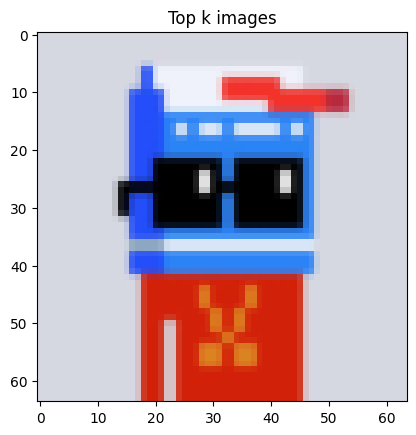

In [33]:
plt.title("Top k images")
plt.imshow(topk_images_grid)

In [34]:
image_tensors = torch.stack(topk_images_tensor)
image_tensors.shape

torch.Size([1, 3, 64, 64])

In [35]:
latents = torch.stack([dataset[i.item()] for i in topk_image_indices])
latents.shape

torch.Size([1, 64])

In [36]:
sparse_encoding = sae.encode(latents.to("cuda"))

# set feature idx to 0, ablation
sparse_encoding[:, feature_idx] = 0
recon_latent = sae.decode(sparse_encoding).view(-1, 4, 4, 4).to("cpu")
recon_images = vae.decode(recon_latent).detach()
# recon_images_list = [to_image((image + 1) * 0.5) for image in recon_images]  
recon_images_list = [to_image((image - image.min()) / (image.max() - image.min()) ) for image in recon_images]  
ablations = make_image_grid(recon_images_list, 1, 1)

Text(0.5, 1.0, 'Ablation')

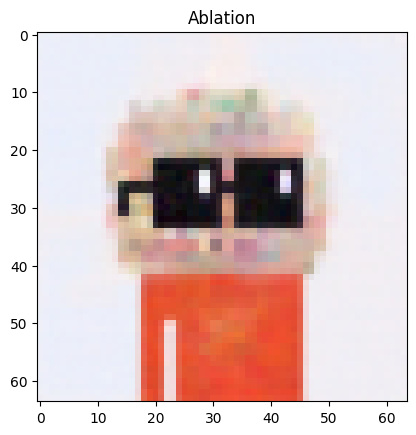

In [37]:
plt.imshow(ablations)
plt.title("Ablation")

In [38]:
def display_three_images(images, titles=None):
    """
    Display three PyTorch tensor images in separate subplots.
    
    Args:
    images (list of torch.Tensor): List of 3 image tensors to display
    titles (list of str, optional): List of 3 titles for each subplot
    """
    if len(images) != 3:
        raise ValueError("This function expects exactly 3 images")
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    for i, (img, ax) in enumerate(zip(images, axes)):
        # Move channel dim to the end for plt.imshow compatibility
        # img = img.permute(1, 2, 0)
        
        # Normalize the image
        # img = img.float()
        # img = (img - img.min()) / (img.max() - img.min())
        
        # Display image
      
        ax.imshow(img)
        
        # Set title if provided
        if titles and i < len(titles):
            ax.set_title(titles[i])
        
        # Remove axes ticks
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.tight_layout()
    plt.show()

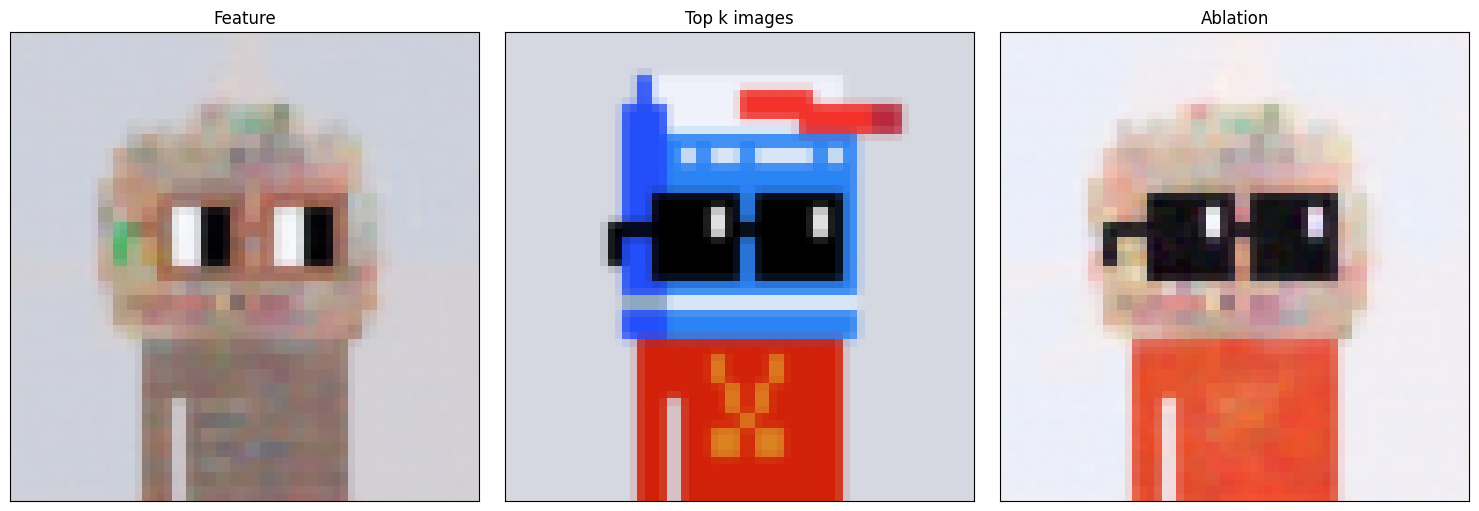

In [39]:
display_three_images([feature_image, topk_images_grid, ablations], ["Feature", "Top k images", "Ablation"])

In [31]:
text_descriptions = [
    nouns_dataset.dataset[i.item()]["text"]
    for i in topk_image_indices
]

text_descriptions

['a pixel art character with square glasses with black frames and red eyes, a zebra-shaped head and a rust-colored body on a cool background']

In [53]:
nouns_dataset.dataset[0]["text"]

'a pixel art character with square black glasses, a hotdog-shaped head and a peachy-colored body on a warm background'